In [1]:
# Load the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
import random
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import keras
from keras import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
import gc
from IPython.display import Markdown, display
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
    
np.random.seed(0) # Add random seed of training for reproducibility

def load_images_from_folder(folder,only_path = False, label = ""):
# Load the paths to the images in a directory
# or load the images
    if only_path == False:
        images = []
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

Using TensorFlow backend.


In [17]:
%cd fruit_data

/home/ec2-user/SageMaker/fruit_data


In [19]:
!rm -r Carambola muskmelon Persimmon Plum Guava Pitaya Pomegranate

In [24]:
%cd ..

/home/ec2-user/SageMaker


In [25]:
# Load the paths on the images
images = []
dirp = "./fruit_data/"
for f in os.listdir(dirp):
    if "png" in os.listdir(dirp+f)[0]:
        images += load_images_from_folder(dirp+f,True,label = f)
    else: 
        for d in os.listdir(dirp+f):
            images += load_images_from_folder(dirp+f+"/"+d,True,label = f)
            
# Create a dataframe with the paths and the label for each fruit
df = pd.DataFrame(images, columns = ["fruit", "path"])

# Shuffle the dataset
from sklearn.utils import shuffle
df = shuffle(df, random_state = 0)
df = df.reset_index(drop=True)

# Assign to each fruit a specific number
fruit_names = sorted(df.fruit.unique())
mapper_fruit_names = dict(zip(fruit_names, [t for t in range(len(fruit_names))]))
df["label"] = df["fruit"].map(mapper_fruit_names)
print(mapper_fruit_names)

# Visualize the resulting dataframe
df.head()

{'Apple': 0, 'Banana': 1, 'Kiwi': 2, 'Mango': 3, 'Orange': 4, 'Peach': 5, 'Pear': 6, 'Tomatoes': 7}


,fruit,path,label
0,Banana,./fruit_data/Banana/Banana01017.png,1
1,Apple,./fruit_data/Apple/Apple C/scene03381.png,0
2,Mango,./fruit_data/Mango/Mango001068.png,3
3,Apple,./fruit_data/Apple/Apple E/Apple E286.png,0
4,Orange,./fruit_data/Orange/Orange001010.png,4


In [30]:
len(mapper_fruit_names)

8

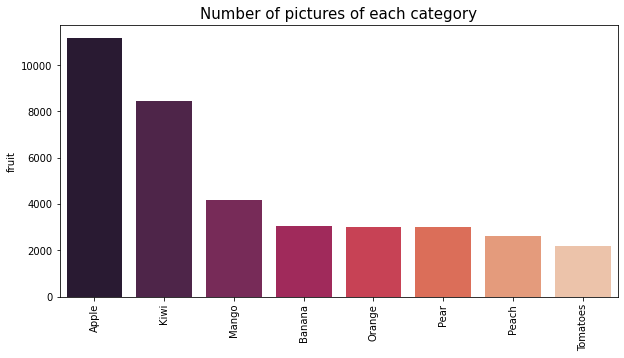

In [26]:
# Display the number of pictures of each category
vc = df["fruit"].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

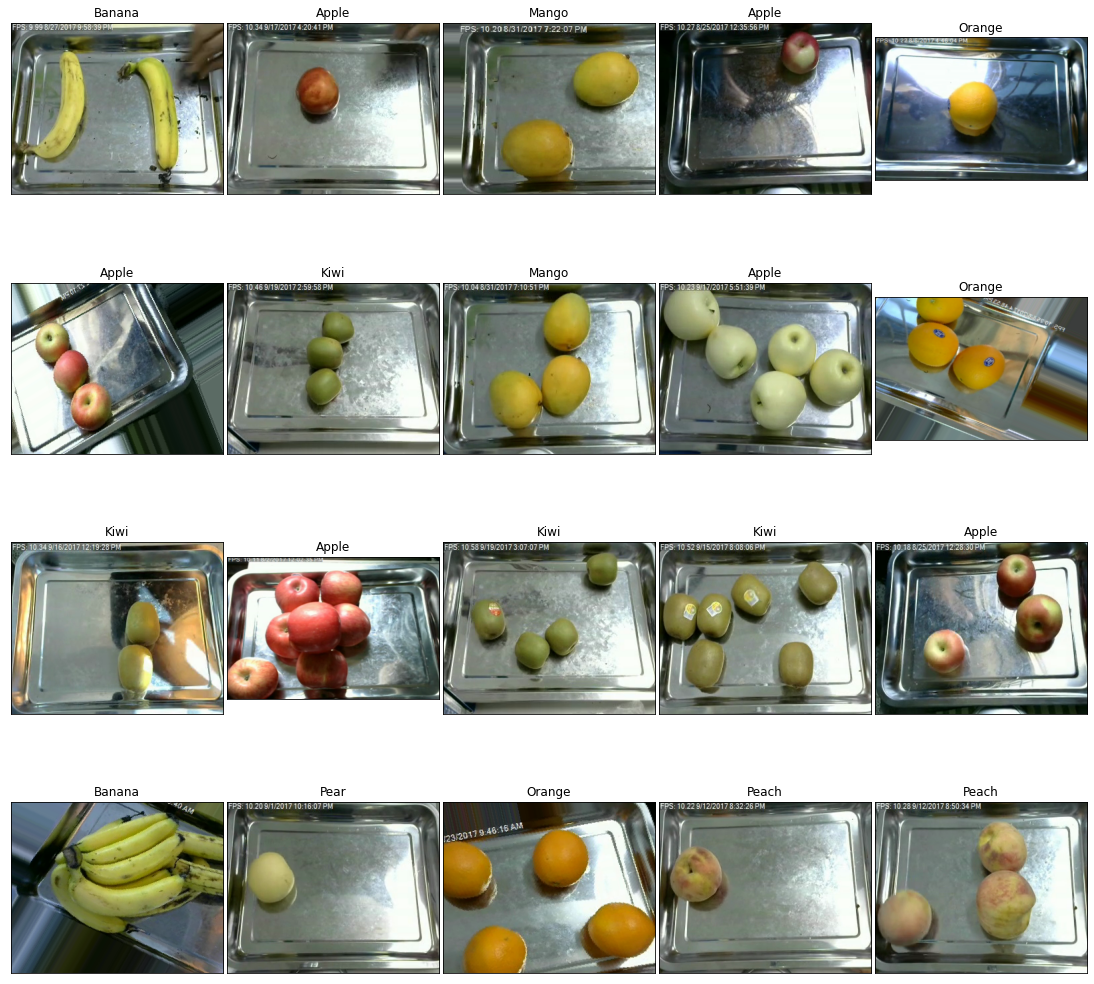

In [27]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.path[i]))
    ax.set_title(df.fruit[i], fontsize = 12)
plt.tight_layout(pad=0.0)
plt.show()

In [38]:
# Use only 5% on the pictures to speed up the training
train_df,test_df = train_test_split(df[['path','fruit']].sample(frac=0.15,random_state=0), test_size=0.2,random_state=0)

In [ ]:
import tensorflow as tf
from time import perf_counter

def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='path',
        y_col='fruit',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
#         rotation_range=30, # Uncomment those lines to use data augmentation
#         zoom_range=0.15,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.15,
#         horizontal_flip=True,
#         fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='path',
        y_col='fruit',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
#         rotation_range=30, # Uncomment those lines to use data augmentation
#         zoom_range=0.15,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.15,
#         horizontal_flip=True,
#         fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='path',
        y_col='fruit',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(len(mapper_fruit_names), activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Dictionary with the models
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
}

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Fit the models
for name, model in models.items():
    
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=50,verbose=0)
    
    # Sav the duration and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_acc']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 4067 validated image filenames belonging to 8 classes.
Found 451 validated image filenames belonging to 8 classes.
Found 1130 validated image filenames belonging to 8 classes.




In [35]:
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.fruit)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
#     printmd(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')

In [36]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,val_accuracy,accuracy,Training time (sec)
0,MobileNetV2,0.6600,0.6976,24.97
1,DenseNet121,0.5933,0.6472,29.12


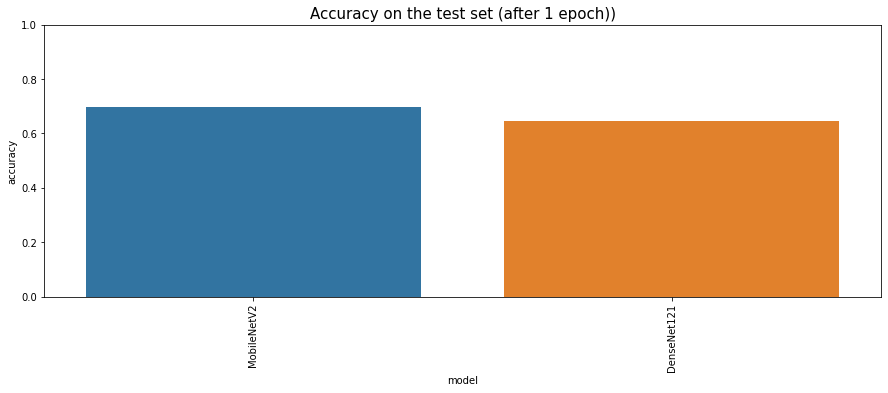

In [37]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()